## Imports

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [2]:
plt.rc("figure", figsize=(10, 6))

In [3]:
years = [2007, 2008]


def get_merged_df():
    dfs = []
    for year in years:
        df = pd.read_csv("./" + str(year) + ".csv")
        dfs.append(df)

    df = pd.concat(dfs)
    return df

df_all = get_merged_df()
df_all.index.rename('ID', inplace=True)

## Carriers

In [4]:
carriers = df_all['UniqueCarrier'].unique()

In [7]:
uc = df_all.groupby(['UniqueCarrier'])

In [8]:
uc[['Year']].count().sort_values('Year', ascending=False)

,Year
UniqueCarrier,
WN,2370625
AA,1238742
OO,1165041
MQ,1031187
UA,939517
US,939036
DL,927820
XE,809283
NW,762178


## Specific carrier

In [5]:
carrier_df = df_all.loc[df_all['UniqueCarrier'] == 'FL']
carrier_df.shape

(524843, 29)

In [6]:
carrier_df_by_year = carrier_df.groupby(['Year'])

### On time analysis

In [7]:
for name, group in carrier_df_by_year: 
    print(name)
    for delay_type in ['ArrDelay', 'DepDelay']:
        delay_type
        delay_group = group[delay_type].dropna()
        print(delay_group.loc[delay_group <= 0].shape[0] / delay_group.shape[0])
        print(delay_group.loc[delay_group >= 15].mean())
    print('\n')

2007
0.5605632068465265
54.12928033255391
0.6103271069286184
54.32235148564245


2008
0.5453185576294968
56.66030764981095
0.634985238458633
58.80779541741717




In [8]:
for name, group in carrier_df_by_year: 
    print(name)
    cancelled = group['Cancelled'].dropna()
    print(cancelled.loc[cancelled == 1].shape[0] / cancelled.shape[0])

2007
0.009887558472254417
2008
0.008544656914446431


In [9]:
for name, group in carrier_df_by_year: 
    print(name)
    print(group.shape[0])

2007
263159
2008
261684


### Delays types

In [10]:
delay_colums = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

In [ ]:
carrier_df_delays_sum = carrier_df[['Year', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']]
print(carrier_df_delays_sum.groupby(['Year']).mean().plot.bar())

In [ ]:
carrier_df_delays_percentage = carrier_df.loc[:,('Year', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay')]
# carrier_df_delays_nz = carrier_df_delays.loc[(carrier_df_delays != 0).any(axis=1), :]
carrier_df_delays_percentage['delay'] = carrier_df_delays_percentage[delay_colums].sum(axis=1)
for column in delay_colums:
    carrier_df_delays_percentage[column] = carrier_df_delays_percentage[column] / carrier_df_delays_percentage['delay']
    
carrier_df_delays_percentage = carrier_df_delays_percentage.drop(columns='delay')
# carrier_df_delays_nz.groupby(['Year']).mean()
# print(carrier_df_delays_percentage.head())
print(carrier_df_delays_percentage.plot.bar())

### Carrier type

Planes, distances, airports, destinations

In [10]:
for name, group in carrier_df_by_year: 
    overall = 0
    for place_type in ['Origin', 'Dest']:
        places = group[place_type].dropna()
        overall += places.unique().shape[0]
    print(overall)

110
120


In [11]:
for name, group in carrier_df_by_year: 
    print(name)
    planes = group['TailNum'].dropna()
    print(planes.unique().shape)

2007
(137,)
2008
(142,)


Using: http://registry.faa.gov/aircraftinquiry/NNum_Results.aspx?MailProcess=1&nNumberTxt=N10156

In [12]:
planes_df = pd.read_csv("./plane-data.csv")
planes_df = planes_df[['TailNum', 'MfrYear']]
planes_df = planes_df.dropna(how='any')
planes_df['MfrYear'] = planes_df['MfrYear'].apply(pd.to_numeric, errors='coerce')
planes_df.tail()

,TailNum,MfrYear
5024,N997DL,1992.0
5025,N998AT,2002.0
5026,N998DL,1992.0
5027,N999CA,1998.0
5028,N999DN,1992.0


In [13]:
for name, group in carrier_df_by_year: 
    group = pd.merge(group, planes_df, on='TailNum', how='left')
    carrier_df_by_plane = group.drop_duplicates(subset=['TailNum'])
    print(carrier_df_by_plane['MfrYear'].mean())

2002.7709923664122
2002.9259259259259


In [14]:
for name, group in carrier_df_by_year: 
    print(name)
    dist = group['Distance'].dropna()
    print(dist.mean())

2007
694.0527969782527
2008
727.1390264593938


## Other

In [ ]:
df_all['ArrDelay'].plot.hist(bins=50, range=(-30,40))

In [ ]:
sns.distplot(df_aa['ArrDelay'].dropna())

In [ ]:
df_aa_delays_nz.plot.hist(density=True, stacked=True, range=(-5,75))

In [ ]:
sns.boxplot(df_aa['ArrDelay'].dropna())

## Correlations

### Delays vs number of flights

In [15]:
def wrap(x):
#     return x.loc[x['ArrDelay'] >= 15].mean()
    return x.loc[x['ArrDelay'] > 0].count() / x['ArrDelay'].count()

[[Text(0,0,'Mon'),
  Text(0,0,'Tue'),
  Text(0,0,'Wed'),
  Text(0,0,'Thu'),
  Text(0,0,'Fri'),
  Text(0,0,'Sat'),
  Text(0,0,'Sun')]]

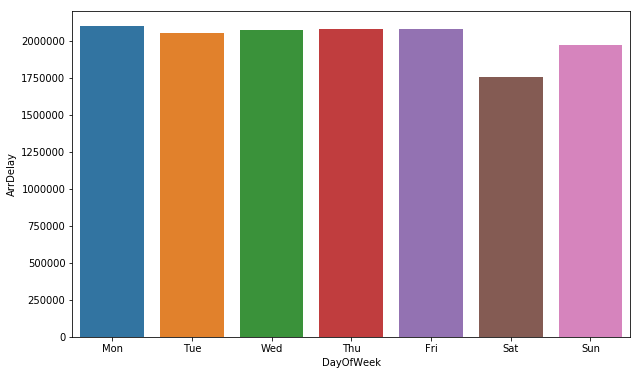

In [16]:
carriers_delay = df_all[['ArrDelay', 'DayOfWeek']].dropna(how='any')
carriers_delay = carriers_delay.groupby(['DayOfWeek'], as_index=False)['ArrDelay'].count()
ax = sns.barplot(x=carriers_delay.DayOfWeek, y=carriers_delay.ArrDelay)
ax.set(xticklabels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

In [164]:
carriers_delay = df_all[['DepDelay', 'DepTime']]
carriers_delay = carriers_delay.dropna(how='any')
carriers_delay['DepTime'] = pd.to_datetime(carriers_delay.DepTime.astype(int).astype(str), format='%H%M', errors='coerce')
carriers_delay['DepTime'] = carriers_delay['DepTime'].dt.hour
carriers_delay['DepDelay'] = carriers_delay['DepDelay'].clip(lower=0)
carriers_delay = carriers_delay.dropna(how='any')
print(carriers_delay.head())

    DepDelay  DepTime
ID                   
0        7.0     12.0
1       13.0     19.0
2       36.0     22.0
3       30.0     12.0
4        1.0      8.0


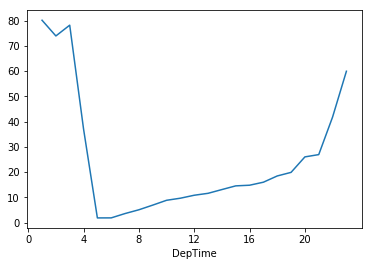

In [172]:
# ax = carriers_delay.plot.scatter(x=carriers_delay.DepTime, y=carriers_delay.DepDelay)
# ax.set(xticklabels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
by_time = carriers_delay.groupby(['DepTime'])['DepDelay'].mean()
time_plot = by_time.plot(xticks=hourly_ticks);

In [173]:
time_plot = time_plot.get_figure()
time_plot.savefig("delay_per_hour.png")

### Speed vs age

#### Take airlines with a highest/lowest diffrence between oldest and newest airplanes

In [174]:
planes_df = pd.read_csv("./plane-data.csv")
planes_df = planes_df[['TailNum', 'MfrYear']]
planes_df['MfrYear'] = planes_df['MfrYear'].apply(pd.to_numeric, errors='coerce')
planes_df = planes_df.dropna(how='any')
planes_df = planes_df[planes_df['MfrYear'] > 0]

carriers_with_planes = pd.merge(df_all, planes_df, on='TailNum', how='left')
print(carriers_with_planes.groupby(['UniqueCarrier'])['MfrYear'].std())
print(carriers_with_planes.groupby(['UniqueCarrier'])['MfrYear'].count())

UniqueCarrier
9E          NaN
AA     5.909415
AQ     7.072778
AS     5.278048
B6     2.062809
CO     5.963525
DL     5.123238
EV     2.456938
F9     1.665094
FL     2.533993
HA     2.956376
MQ     2.304371
NW    12.721570
OH     4.767610
OO     3.831842
UA     4.764130
US     6.294898
WN     6.820248
XE     2.338697
YV     3.335514
Name: MfrYear, dtype: float64
UniqueCarrier
9E          0
AA     595527
AQ      44862
AS     290898
B6     359350
CO     585596
DL     908182
EV     511792
F9     189079
FL     501760
HA     109684
MQ     762469
NW     716398
OH     386938
OO    1112354
UA     906257
US     851369
WN    2215392
XE     772711
YV     486663
Name: MfrYear, dtype: int64


#### Compare speed and age of airplanes

In [201]:
carriers_subset = df_all.loc[df_all['UniqueCarrier'].isin(['NW', 'MQ'])]

120000


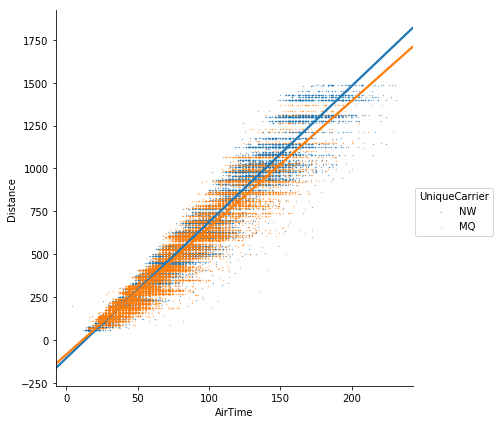

In [262]:
carriers_distance = carriers_subset[['UniqueCarrier','AirTime', 'Distance']]
carriers_distance = carriers_distance.sample(50000)
carriers_distance = carriers_distance[carriers_distance['Distance'] < 1500]
carriers_distance.dropna(how='any')
print(carriers_delay.size)
distance_plot = sns.lmplot(x='AirTime', y='Distance', data=carriers_distance, hue='UniqueCarrier', scatter_kws={"s": 0.1}, size=6)

In [263]:
distance_plot.savefig("distance_per_air_time.png")

In [207]:
carriers_speed = carriers_subset.loc[:,('UniqueCarrier','AirTime', 'Distance', 'TailNum')]
carriers_speed['Speed'] = carriers_speed['Distance'] / carriers_speed['AirTime']
carriers_speed = carriers_speed.drop(columns=['AirTime', 'Distance'])
carriers_speed.columns

Index(['UniqueCarrier', 'TailNum', 'Speed'], dtype='object')

In [270]:
planes_df = pd.read_csv("./plane-data.csv")
planes_df = planes_df[['TailNum', 'MfrYear']]
planes_df['MfrYear'] = planes_df['MfrYear'].apply(pd.to_numeric, errors='coerce')
planes_df = planes_df.dropna(how='any')
planes_df = planes_df[planes_df['MfrYear'] > 0]

carriers_with_planes = pd.merge(carriers_speed, planes_df, on='TailNum', how='left')
print(carriers_with_planes.groupby(['UniqueCarrier'])['MfrYear'].mean())
carriers_with_planes.groupby(['UniqueCarrier'])[['Speed', 'MfrYear']].corr()

UniqueCarrier
MQ    2001.774093
NW    1988.222573
Name: MfrYear, dtype: float64


Speed   MfrYear
UniqueCarrier                            
MQ            Speed    1.000000  0.127369
              MfrYear  0.127369  1.000000
NW            Speed    1.000000  0.395216
              MfrYear  0.395216  1.000000

/home/rzepinskip/.pyenv/versions/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


        UniqueCarrier TailNum     Speed  MfrYear  FlightsNo
389262             NW  N358NB  5.309524   2003.0         24
818233             MQ  N649PP  7.418182   2000.0         36
1544060            NW  N613NW  5.263158   1969.0         37
48482              NW  N365NW  7.400966   1999.0         37
1560842            MQ  N636AE  7.133333   1999.0         47


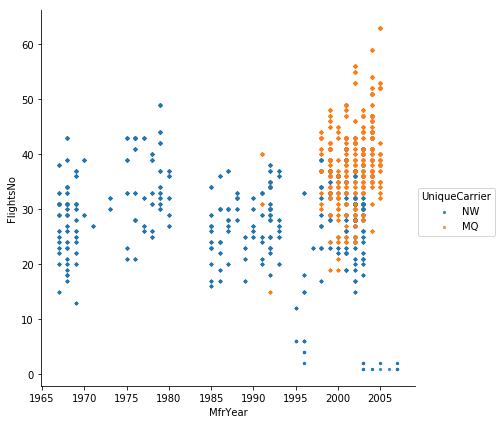

In [254]:
carriers_flights_by_plane = carriers_with_planes.dropna(how='any')
# df['Counts'] = df.groupby(['Color'])['Value'].transform('count')
carriers_flights_by_plane['FlightsNo'] = carriers_flights_by_plane.groupby(['TailNum'])['UniqueCarrier'].transform('count')
print(carriers_flights_by_plane.head())
flights_plot = sns.lmplot(x='MfrYear', y='FlightsNo', data=carriers_flights_by_plane, hue='UniqueCarrier', scatter_kws={"s": 5}, fit_reg=False, size=6)

In [255]:
# flights_plot = flights_plot.get_figure()
flights_plot.savefig("flights_per_mfr_year.png")

80000


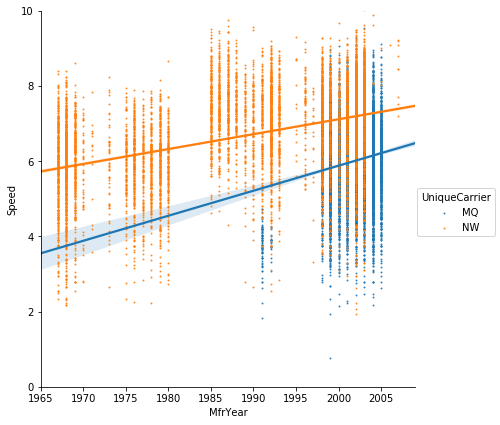

In [285]:
carriers_planes_speeds = carriers_with_planes.sample(20000)
carriers_planes_speeds.dropna(how='any')
print(carriers_planes_speeds.size)
speeds_plot = sns.lmplot(x='MfrYear', y='Speed', data=carriers_planes_speeds, hue='UniqueCarrier', scatter_kws={"s": 1}, size=6)
speeds_plot.set(ylim=(0, 10))

In [286]:
speeds_plot.savefig("speed_per_mfr_year.png")